In [1]:
# !pip install tensorflow
# !pip install wfdb
# !pip install ast
# !pip install ecg_plot
# !pip install missingno
# !pip install neurokit2
# !pip install tensorflow_addons

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras import layers
from keras.layers import InputLayer
from tensorflow.keras.layers import Layer, Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalAveragePooling1D, Dense, Add, Multiply, Reshape
from keras.layers import concatenate
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten, Embedding, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, ZeroPadding1D, LSTM, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Sequential, Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
import neurokit2 as nk
import numpy as np
import missingno as msno
from scipy.io.arff import loadarff
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import r2_score
import wfdb
import ast
import ecg_plot
from scipy.signal import butter, lfilter, find_peaks

# Load data

In [3]:
path = 'C:/Users/Windows10/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# load and convert annotation data
ecg_df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
ecg_df.scp_codes = ecg_df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
ecg_data = load_raw_data(ecg_df, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [5]:
# Apply diagnostic superclass
ecg_df['diagnostic_superclass'] = ecg_df.scp_codes.apply(aggregate_diagnostic)

# Remove records with more than 1 diagnostic superclass
filter_mask = ecg_df['diagnostic_superclass'].apply(lambda x: len(x) == 1)
ECG_df = ecg_df[filter_mask]
ECG_data = ecg_data[filter_mask]
print("Before filtering:",ecg_df.shape)
print("Before filtering:",ecg_data.shape)
print("After filtering:",ECG_df.shape)
print("After filtering:",ECG_data.shape)

Before filtering: (21799, 28)
Before filtering: (21799, 1000, 12)
After filtering: (16244, 28)
After filtering: (16244, 1000, 12)


# Data preprocessing

In [6]:
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [12]:
ECG_data

array([[[-1.190e-01, -5.500e-02,  6.400e-02, ..., -2.600e-02,
         -3.900e-02, -7.900e-02],
        [-1.160e-01, -5.100e-02,  6.500e-02, ..., -3.100e-02,
         -3.400e-02, -7.400e-02],
        [-1.200e-01, -4.400e-02,  7.600e-02, ..., -2.800e-02,
         -2.900e-02, -6.900e-02],
        ...,
        [ 6.900e-02,  0.000e+00, -6.900e-02, ...,  2.400e-02,
         -4.100e-02, -5.800e-02],
        [ 8.600e-02,  4.000e-03, -8.100e-02, ...,  2.420e-01,
         -4.600e-02, -9.800e-02],
        [ 2.200e-02, -3.100e-02, -5.400e-02, ...,  1.430e-01,
         -3.500e-02, -1.200e-01]],

       [[ 4.000e-03,  1.380e-01,  1.340e-01, ...,  1.920e-01,
          8.300e-02,  8.800e-02],
        [-2.000e-02,  1.160e-01,  1.360e-01, ...,  1.560e-01,
          5.700e-02,  6.300e-02],
        [-5.300e-02,  9.200e-02,  1.450e-01, ...,  1.070e-01,
          1.300e-02,  2.200e-02],
        ...,
        [ 1.210e-01,  3.980e-01,  2.770e-01, ..., -1.065e+00,
         -4.920e-01, -1.560e-01],
        [-3.

<class 'pandas.core.frame.DataFrame'>
Index: 16244 entries, 1 to 21837
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    16244 non-null  float64
 1   age                           16244 non-null  float64
 2   sex                           16244 non-null  int64  
 3   height                        5161 non-null   float64
 4   weight                        7515 non-null   float64
 5   nurse                         15244 non-null  float64
 6   site                          16234 non-null  float64
 7   device                        16244 non-null  object 
 8   recording_date                16244 non-null  object 
 9   report                        16244 non-null  object 
 10  scp_codes                     16244 non-null  object 
 11  heart_axis                    9812 non-null   object 
 12  infarction_stadium1           2627 non-null   object 
 13  infarc

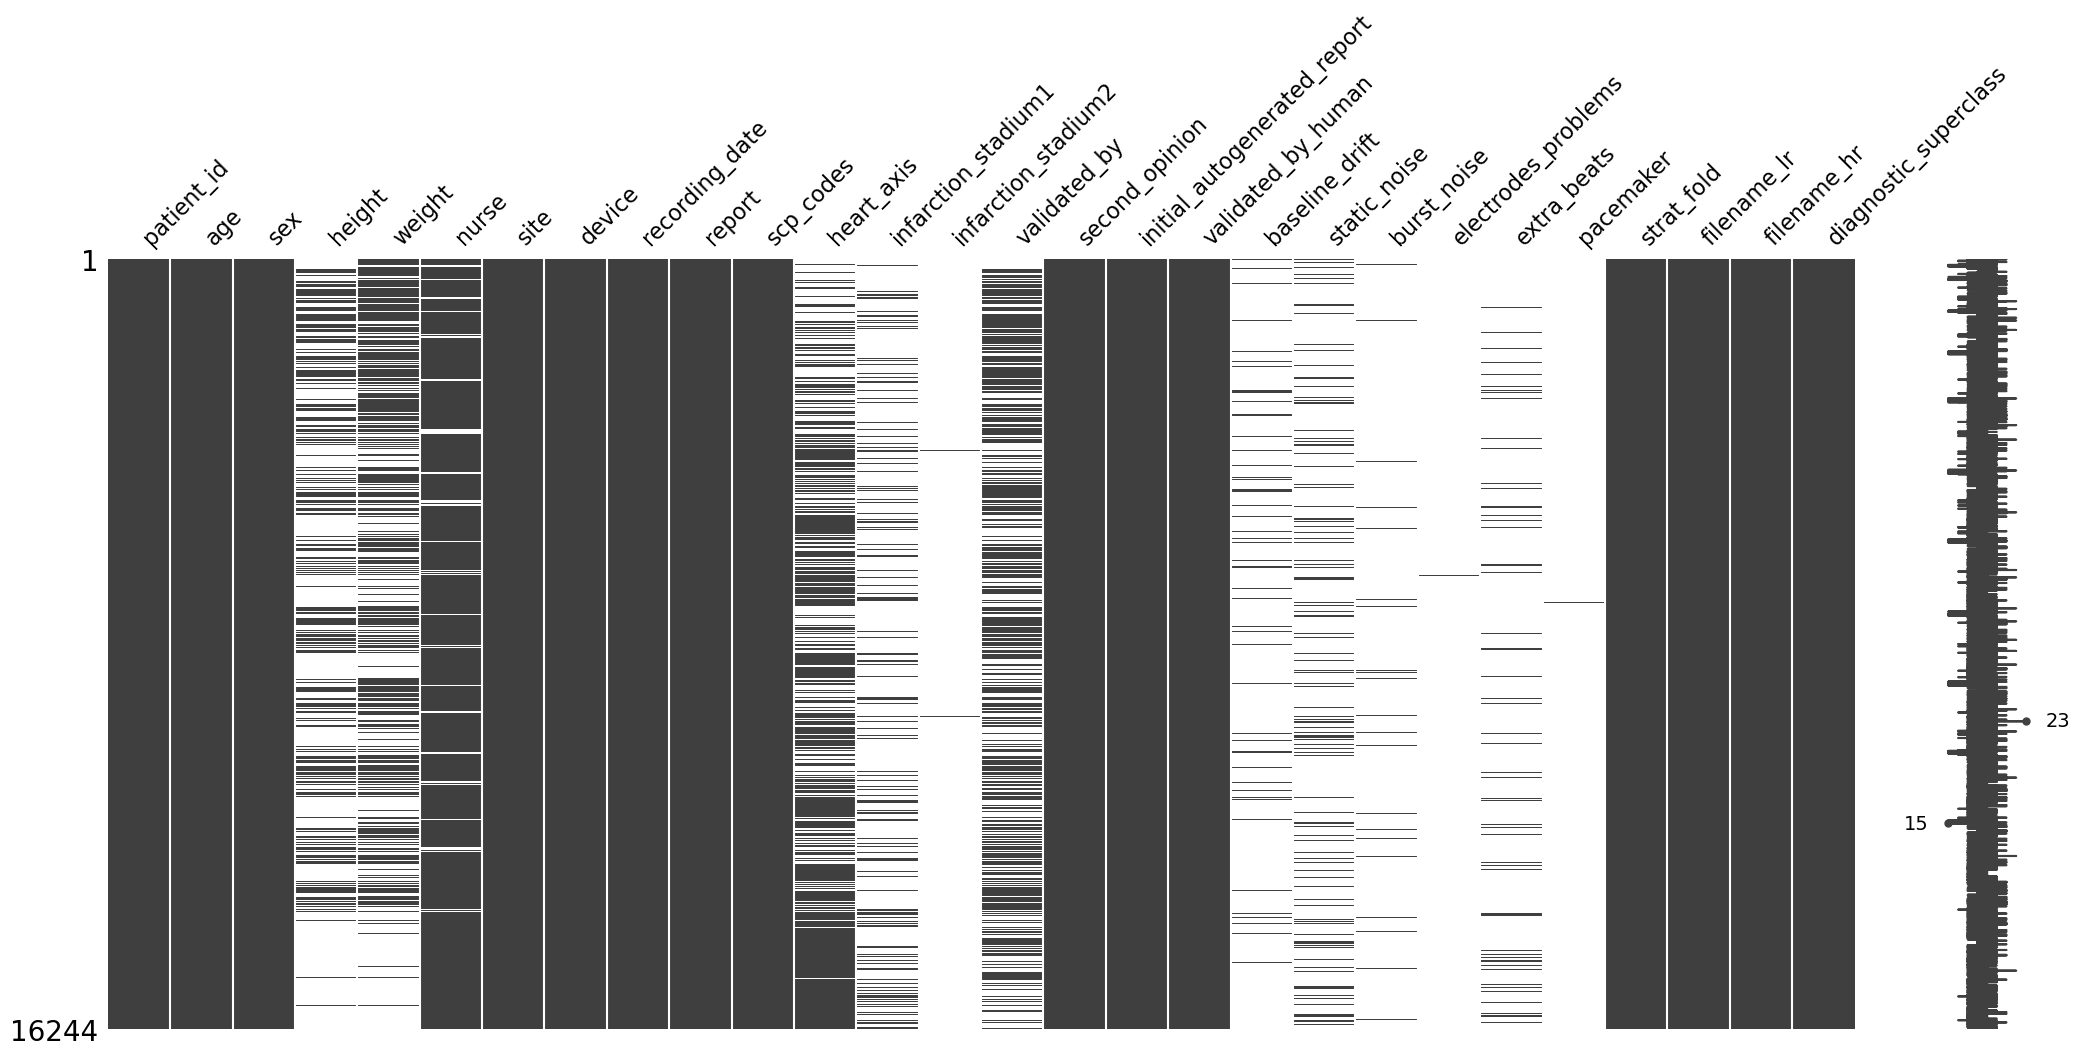

In [8]:
# Check for missing values
MissingValue = ECG_df.info()
print(MissingValue)
msno.matrix(ECG_df)
plt.show()

In [9]:
# Calculate the median of the height and weight columns
median_height = ECG_df['height'].median()
median_weight = ECG_df['weight'].median()

# Fill missing values with the median
ECG_df['height'].fillna(median_height, inplace=True)
ECG_df['weight'].fillna(median_weight, inplace=True)

diagnostic_superclass
[NORM]    9069
[MI]      2532
[STTC]    2400
[CD]      1708
[HYP]      535
Name: count, dtype: int64


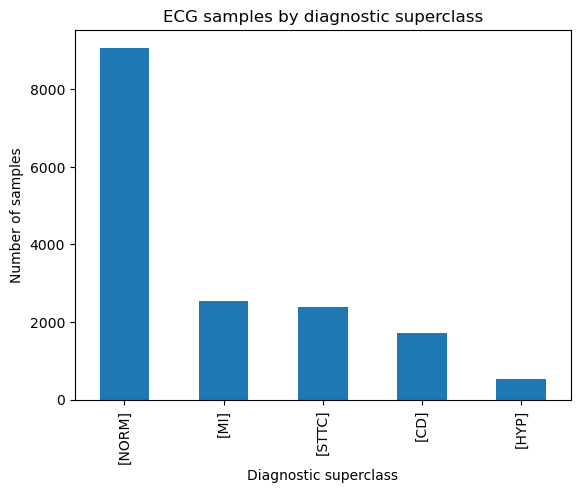

In [9]:
# Count the number of samples in each diagnostic superclass
value_counts = ECG_df.diagnostic_superclass.value_counts()
print(value_counts)
value_counts.plot(kind='bar')
plt.xlabel("Diagnostic superclass")
plt.ylabel("Number of samples")
plt.title("ECG samples by diagnostic superclass")
plt.show()

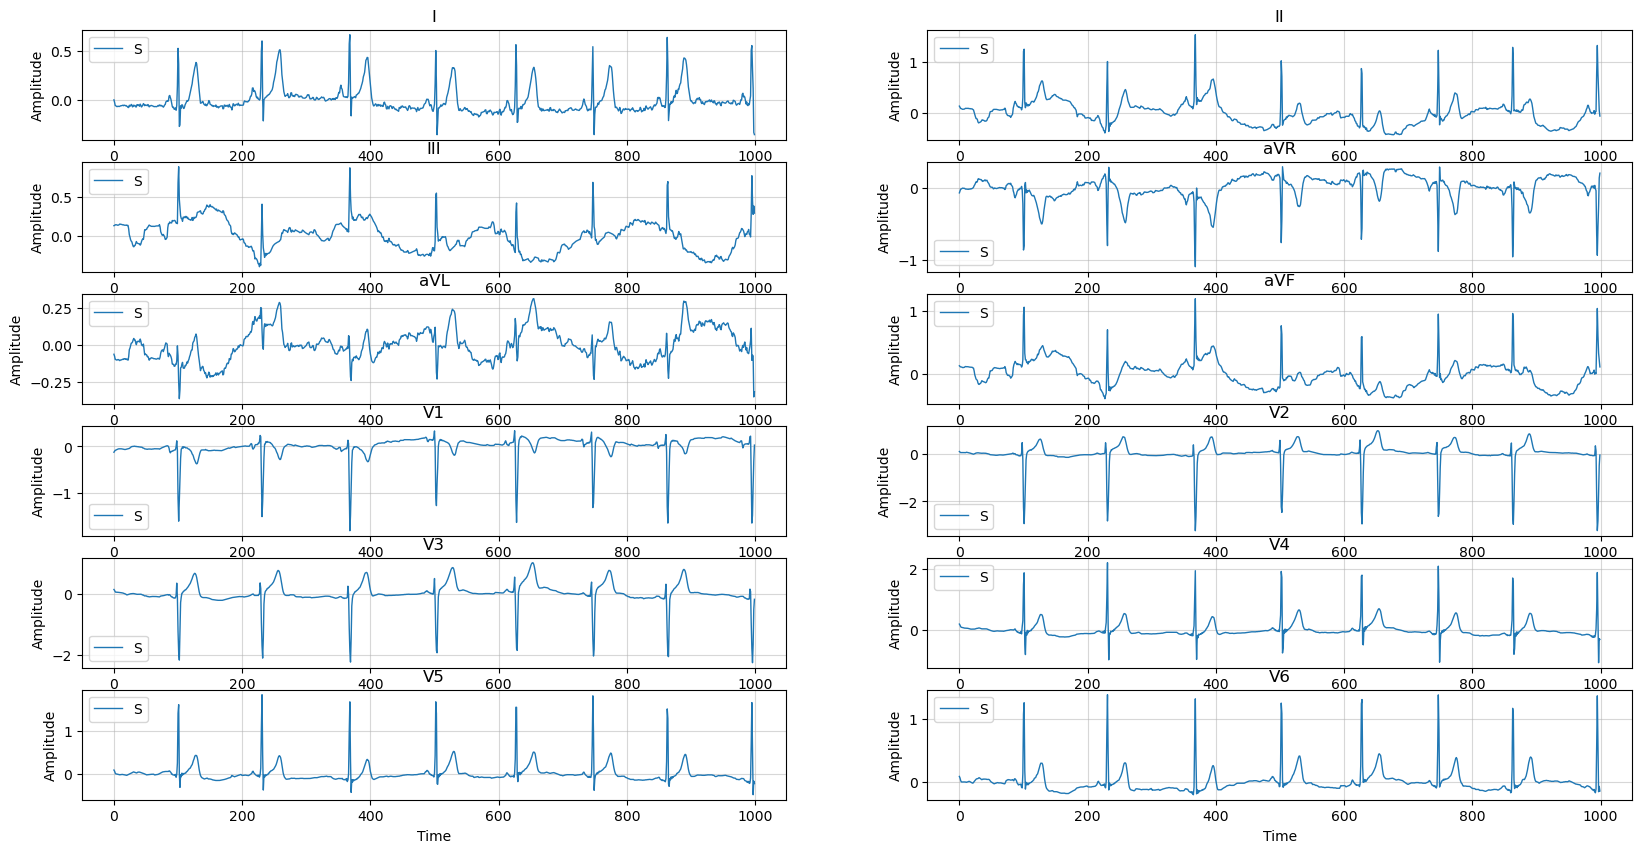

In [6]:
# Plot the 12 leads of the first ECG signal
ecg_plot = ECG_data[1]
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for index in range(12):
    plt.subplot(6,2,index+1)
    plt.plot(ecg_plot[:,index], linewidth=1)
    
    plt.gca()
    plt.title(titles[index])
    plt.xlabel('Time')
    plt.ylabel('Amplitude') 
    plt.legend('Signal')

plt.show()

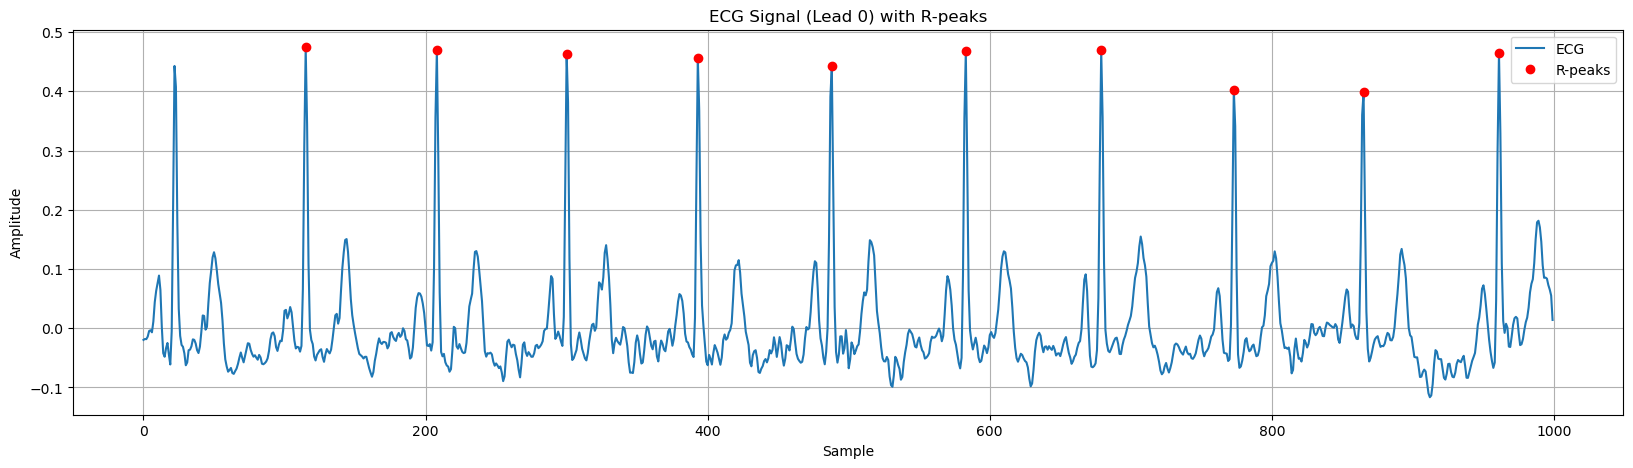

In [43]:
# Select the first lead of the ECG signal
selected_lead_data = ECG_data[0, :, 0]

# Reshape the data into a one-dimensional array
flattened_data = np.ravel(selected_lead_data)

# Clean the ECG signal
cleaned = nk.ecg_clean(flattened_data, sampling_rate=100)

#Locate the R-peaks
rpeaks = nk.ecg_findpeaks(cleaned, sampling_rate=100, method='neurokit')

# Plot the cleaned ECG signal and the R-peaks
plt.figure(figsize=(20, 5))
plt.plot(cleaned, label='Signal')
plt.plot(rpeaks['ECG_R_Peaks'], cleaned[rpeaks['ECG_R_Peaks']], 'ro', label='R-peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(f'ECG Signal (Lead {lead_index}) with R-peaks')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# calculate the moving average
def moving_average(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

channels = 12
filtered_ecg = np.ones_like(ECG_data)

# Use tqdm to create a progress bar
for index in tqdm(range(len(ECG_data)), desc='Filtering ECG Data', unit='sample'):
    for channel in range(channels):
        filtered_ecg[index][:, channel] = moving_average(ECG_data[index][:, channel], 5)

print("SUCESS!")

Filtering ECG Data: 100%|███████████████████████████████████████████████████| 16244/16244 [00:36<00:00, 442.54sample/s]

SUCESS!


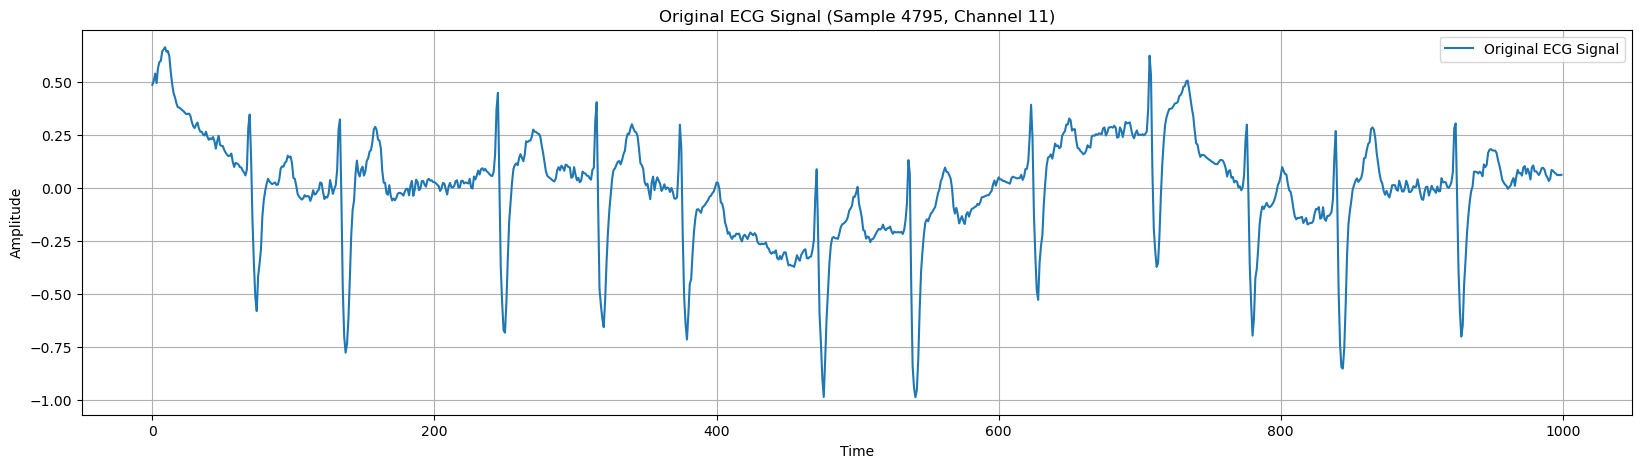

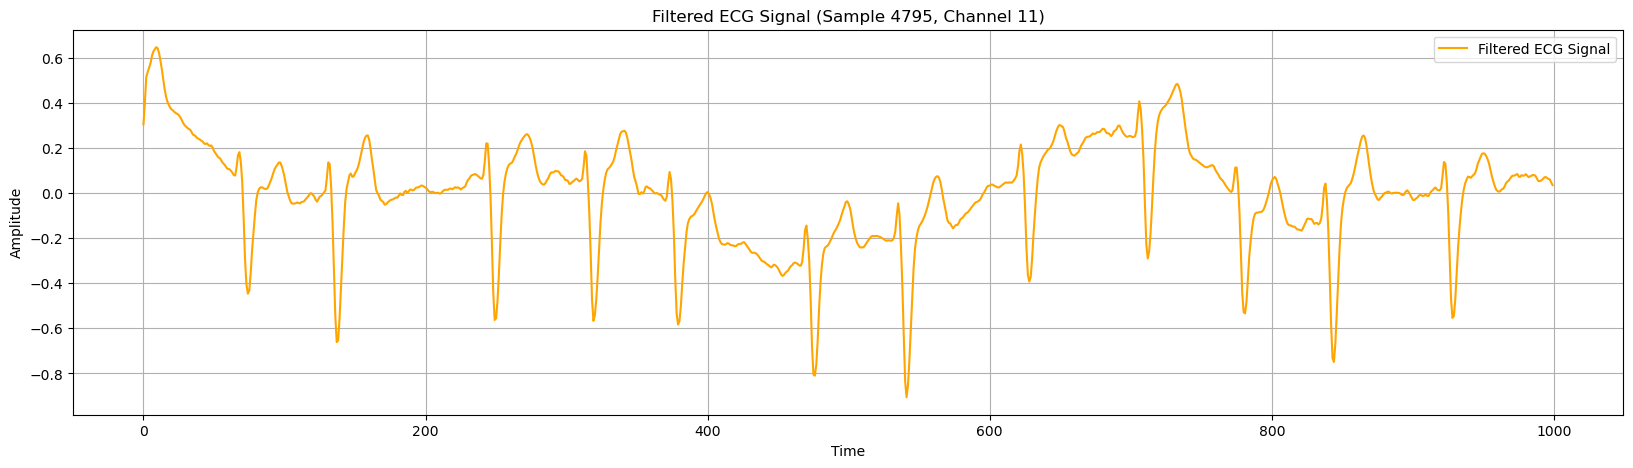

In [36]:
# Select a random sample and channel
sample_index = np.random.randint(ECG_data.shape[0])
channel_to_plot = np.random.randint(ECG_data.shape[2])

# Plot the original ECG signal
plt.figure(figsize=(20, 5))
plt.plot(ECG_data[sample_index, :, channel_to_plot], label='Original ECG Signal')
plt.title('Original ECG Signal (Sample {}, Channel {})'.format(sample_index, channel_to_plot))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Plot the filtered ECG signal
plt.figure(figsize=(20, 5))
plt.plot(filtered_ecg[sample_index, :, channel_to_plot], label='Filtered ECG Signal', color='orange')
plt.title('Filtered ECG Signal (Sample {}, Channel {})'.format(sample_index, channel_to_plot))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Binary for each label
CD = [1, 0, 0, 0, 0] , 
HYP = [0, 1, 0, 0, 0] ,
MI = [0, 0, 1, 0, 0] ,
NORM = [0, 0, 0, 1, 0] ,
STTC= [0, 0, 0, 0, 1] 

NORM = 3 
MI = 2
STTC = 4
CD = 0
HYP = 1

In [7]:
#Takes the first character of the string and converts it to an integer
ECG_df.diagnostic_superclass = ECG_df.diagnostic_superclass.apply(lambda x: x[0])
label_encoder = LabelEncoder()
ECG_df['diagnostic_superclass'] = label_encoder.fit_transform(ECG_df['diagnostic_superclass'])
ECG_df['diagnostic_superclass'].value_counts()

diagnostic_superclass
3    9069
2    2532
4    2400
0    1708
1     535
Name: count, dtype: int64

# Data training

In [8]:

# Train
X_train = filtered_ecg[np.where(ECG_df.strat_fold <= 8)]
y_train = ECG_df[(ECG_df.strat_fold <= 8)].diagnostic_superclass
#validation
X_valid = filtered_ecg[np.where(ECG_df.strat_fold == 9)]
y_valid = ECG_df[ECG_df.strat_fold == 9].diagnostic_superclass
# Test
X_test = filtered_ecg[np.where(ECG_df.strat_fold == 10)]
y_test = ECG_df[ECG_df.strat_fold == 10].diagnostic_superclass


In [9]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test= to_categorical(y_test)


In [10]:
print(f"Shape of Train Data X_Train/ECG : {X_train.shape}")
print(f"Shape of Train Data y_Train/Class : {y_train.shape}")
print("===================================================")
print(f"Shape of Validation Data X_valid/ECG : {X_valid.shape}")
print(f"Shape of Validation Data y_valid/Class : {y_valid.shape}")
print("===================================================")
print(f"Shape of Test Data X_Test/ECG : {X_test.shape}")
print(f"Shape of Test Data y_Test/Class : {y_test.shape}")

Shape of Train Data X_Train/ECG : (12957, 1000, 12)
Shape of Train Data y_Train/Class : (12957, 5)
Shape of Validation Data X_valid/ECG : (1637, 1000, 12)
Shape of Validation Data y_valid/Class : (1637, 5)
Shape of Test Data X_Test/ECG : (1650, 1000, 12)
Shape of Test Data y_Test/Class : (1650, 5)


# Enhanced Fully Convolutional Network (FCN)

In [13]:
tf.keras.backend.clear_session()

class SqueezeExciteBlock(Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeExciteBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        filters = input_shape[-1]
        self.pooling = GlobalAveragePooling1D()
        self.dense1 = Dense(filters // self.ratio, activation='relu')
        self.dense2 = Dense(filters, activation='sigmoid')
        self.reshape = Reshape((1, filters))

    def call(self, inputs):
        se = self.pooling(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = self.reshape(se)
        se = Multiply()([inputs, se])
        return se

FCN_model = Sequential()
  
FCN_model.add(Conv1D(filters = 128, kernel_size = 8, activation='relu', padding = 'same', input_shape = (1000, 12)))
FCN_model.add(BatchNormalization())  


FCN_model.add(Conv1D(filters = 256, kernel_size = 5, activation='relu', padding = 'same'))
FCN_model.add(BatchNormalization())


FCN_model.add(Conv1D(filters = 128, kernel_size = 3, activation='relu', padding = 'same'))
FCN_model.add(BatchNormalization())

FCN_model.add(SqueezeExciteBlock())

FCN_model.add(GlobalAveragePooling1D())
FCN_model.add(Dense(units = 5, activation='softmax'))

optm = Adam(learning_rate=0.0001)
FCN_model.compile(optimizer = optm, loss = 'categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'],run_eagerly=True)
print(FCN_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 128)         12416     
                                                                 
 batch_normalization (Batch  (None, 1000, 128)         512       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 256)         164096    
                                                                 
 batch_normalization_1 (Bat  (None, 1000, 256)         1024      
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 1000, 128)         98432     
                                                                 
 batch_normalization_2 (Bat  (None, 1000, 128)         5

In [16]:
# Define callbacks to stop training if the validation loss doesn't improve after 10 epochs
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

In [48]:
# Fit the model
historyfcn = FCN_model.fit(X_train, y_train, epochs = 30, batch_size=128, callbacks=callbacks_list, validation_data=(X_valid, y_valid))

Epoch 1/30
102/102 [==============================] - 191s 2s/step - loss: 0.4159 - accuracy: 0.8563 - precision: 0.8818 - recall: 0.8271 - val_loss: 0.7214 - val_accuracy: 0.7520 - val_precision: 0.7708 - val_recall: 0.7233
Epoch 2/30
102/102 [==============================] - 208s 2s/step - loss: 0.4074 - accuracy: 0.8575 - precision: 0.8857 - recall: 0.8270 - val_loss: 0.6930 - val_accuracy: 0.7636 - val_precision: 0.7802 - val_recall: 0.7306
Epoch 3/30
102/102 [==============================] - 182s 2s/step - loss: 0.4040 - accuracy: 0.8606 - precision: 0.8879 - recall: 0.8291 - val_loss: 0.6976 - val_accuracy: 0.7642 - val_precision: 0.7777 - val_recall: 0.7330
Epoch 4/30
102/102 [==============================] - 198s 2s/step - loss: 0.4042 - accuracy: 0.8598 - precision: 0.8849 - recall: 0.8311 - val_loss: 0.7013 - val_accuracy: 0.7569 - val_precision: 0.7761 - val_recall: 0.7349
Epoch 5/30
102/102 [==============================] - 195s 2s/step - loss: 0.3997 - accuracy: 0.8620

# AlexNet

In [28]:
tf.keras.backend.clear_session()

alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, activation='relu', kernel_size=11, strides=4, input_shape=(1000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

alexNet_model.add(Flatten())
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.5))
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.5))
alexNet_model.add(Dense(5, activation='softmax'))

alexNet_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy',
                                                                                    keras.metrics.Precision(name='precision'),
                                                                                    keras.metrics.Recall(name='recall'),
                                                                                    tfa.metrics.F1Score(num_classes=5)])
print(alexNet_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 248, 96)           12768     
                                                                 
 batch_normalization (Batch  (None, 248, 96)           384       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 124, 96)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 256)          123136    
                                                                 
 batch_normalization_1 (Bat  (None, 124, 256)          1024      
 chNormalization)                                                
                                                       

In [46]:
# Fit the model
alexnet = alexNet_model.fit(X_train, y_train, epochs = 30, batch_size = 64,callbacks=callbacks_list, validation_data=(X_valid, y_valid))

Epoch 1/30
203/203 [==============================] - 113s 544ms/step - loss: 0.6243 - accuracy: 0.8064 - precision: 0.8360 - recall: 0.7737 - f1_score: 0.6973 - val_loss: 0.7942 - val_accuracy: 0.7398 - val_precision: 0.7923 - val_recall: 0.6524 - val_f1_score: 0.5580
Epoch 2/30
203/203 [==============================] - 113s 558ms/step - loss: 0.5840 - accuracy: 0.8093 - precision: 0.8402 - recall: 0.7753 - f1_score: 0.6933 - val_loss: 0.8902 - val_accuracy: 0.7263 - val_precision: 0.7770 - val_recall: 0.6726 - val_f1_score: 0.5560
Epoch 3/30
203/203 [==============================] - 111s 545ms/step - loss: 0.5408 - accuracy: 0.8223 - precision: 0.8513 - recall: 0.7902 - f1_score: 0.7202 - val_loss: 1.0750 - val_accuracy: 0.7385 - val_precision: 0.7670 - val_recall: 0.6940 - val_f1_score: 0.5780
Epoch 4/30
203/203 [==============================] - 110s 541ms/step - loss: 0.4853 - accuracy: 0.8375 - precision: 0.8654 - recall: 0.8076 - f1_score: 0.7539 - val_loss: 1.0842 - val_accur

# ResNet-50

In [29]:
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv1D(F1, kernel_size=1, strides=s, name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)

    X_shortcut = Conv1D(filters=F3, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)


    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    return X

def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)


    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape=(1000, 12), classes=5):
    X_input = Input(input_shape)
    X = ZeroPadding1D(3)(X_input)
    X = Conv1D(64, 7, strides=2, name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=2)(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block='b')
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block='b')
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block='c')
    X = identity_block(X, f=3, filters=[128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='b')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='c')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='d')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='e')
    X = identity_block(X, f=3, filters=[256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block='b')
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block='c')

    X = GlobalAveragePooling1D()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='SE_ResNet50')

    return model

In [30]:
#Compile the model
ResNet50_model = ResNet50(input_shape = (1000,12), classes = 5)
ResNet50_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy',
                                                                                    keras.metrics.Precision(name='precision'),
                                                                                    keras.metrics.Recall(name='recall'),
                                                                                    tfa.metrics.F1Score(num_classes=5)])
print(ResNet50_model.summary())


Model: "SE_ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 12)]           0         []                            
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 1006, 12)             0         ['input_1[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1 (Conv1D)              (None, 500, 64)              5440      ['zero_padding1d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 500, 64)              256       ['conv1[0][0]']     

In [20]:
#Fit the model
ResNet50 = ResNet50_model.fit(X_train, y_train, epochs = 30, batch_size = 64,callbacks=callbacks_list, validation_data=(X_valid, y_valid))

Epoch 1/30
203/203 [==============================] - 489s 2s/step - loss: 1.0787 - accuracy: 0.6669 - precision: 0.7326 - recall: 0.5764 - f1_score: 0.4445 - val_loss: 1.7284 - val_accuracy: 0.3769 - val_precision: 0.4077 - val_recall: 0.2389 - val_f1_score: 0.2050
Epoch 2/30
203/203 [==============================] - 466s 2s/step - loss: 0.7576 - accuracy: 0.7467 - precision: 0.7918 - recall: 0.6925 - f1_score: 0.5861 - val_loss: 2.3403 - val_accuracy: 0.6927 - val_precision: 0.7229 - val_recall: 0.6646 - val_f1_score: 0.4697
Epoch 3/30
203/203 [==============================] - 468s 2s/step - loss: 0.6985 - accuracy: 0.7613 - precision: 0.8016 - recall: 0.7144 - f1_score: 0.6069 - val_loss: 0.8625 - val_accuracy: 0.7355 - val_precision: 0.7678 - val_recall: 0.6927 - val_f1_score: 0.5391
Epoch 4/30
203/203 [==============================] - 461s 2s/step - loss: 0.6363 - accuracy: 0.7776 - precision: 0.8161 - recall: 0.7360 - f1_score: 0.6478 - val_loss: 1.1027 - val_accuracy: 0.6127 

# Test

52/52 [==============================] - 13s 230ms/step - loss: 0.6617 - accuracy: 0.7624 - precision: 0.7875 - recall: 0.7345 - f1_score: 0.6296


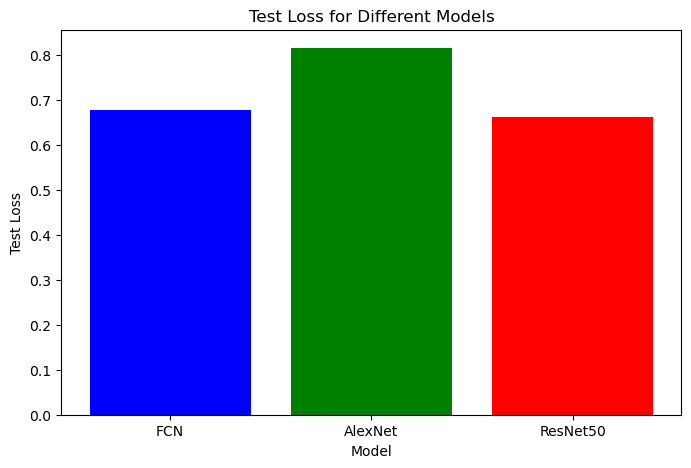

In [37]:
scores_FCN_model = FCN_model.evaluate(X_test, y_test)
lossFCN_model = scores_FCN_model[0]
scores_alexNet_model = AlexNet_model.evaluate(X_test, y_test)
lossalexNet_model = scores_alexNet_model[0]
scores_Resnet50 = ResNet50_model.evaluate(X_test, y_test)
lossResnet50 = scores_Resnet50[0]


test_losses = [lossFCN_model, lossalexNet_model, lossResnet50]
model_names = ['FCN', 'AlexNet', 'ResNet50']

# Plot test loss for each model
plt.figure(figsize=(8, 5))
plt.bar(model_names, test_losses, color=['blue', 'green', 'red'])
plt.title('Test Loss for Different Models')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.show()

In [24]:
#Classification report for FCN
FCN_predict = FCN_model.predict(X_test)
FCN_matrix = confusion_matrix(y_test.argmax(axis=1),FCN_predict.argmax(axis=1))
FCN_report = classification_report(y_test.argmax(axis=1), FCN_predict.argmax(axis=1))
print(FCN_report)

52/52 [==============================] - 4s 75ms/step
              precision    recall  f1-score   support

           0       0.88      0.61      0.72       184
           1       0.75      0.21      0.33        56
           2       0.71      0.47      0.57       256
           3       0.77      0.96      0.86       912
           4       0.72      0.63      0.67       242

    accuracy                           0.77      1650
   macro avg       0.77      0.58      0.63      1650
weighted avg       0.77      0.77      0.75      1650



In [32]:
#Classification report for AlexNet
alexNet_predict = AlexNet_model.predict(X_test)
alexNet_matrix = confusion_matrix(y_test.argmax(axis=1),alexNet_predict.argmax(axis=1))
alexNet_report = classification_report(y_test.argmax(axis=1), alexNet_predict.argmax(axis=1))
print(alexNet_report)

52/52 [==============================] - 4s 45ms/step
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       184
           1       0.28      0.09      0.14        56
           2       0.68      0.32      0.44       256
           3       0.76      0.93      0.84       912
           4       0.60      0.64      0.62       242

    accuracy                           0.73      1650
   macro avg       0.62      0.51      0.54      1650
weighted avg       0.71      0.73      0.70      1650



In [36]:
#Classification report for ResNet50
ResNet50_model_predict = ResNet50_model.predict(X_test)
ResNet50_model_matrix = confusion_matrix(y_test.argmax(axis=1),ResNet50_model_predict.argmax(axis=1))
ResNet50_model_report = classification_report(y_test.argmax(axis=1), ResNet50_model_predict.argmax(axis=1))
print(ResNet50_model_report)

52/52 [==============================] - 13s 221ms/step
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       184
           1       0.39      0.20      0.26        56
           2       0.62      0.71      0.66       256
           3       0.81      0.88      0.85       912
           4       0.74      0.57      0.64       242

    accuracy                           0.76      1650
   macro avg       0.68      0.60      0.63      1650
weighted avg       0.76      0.76      0.76      1650



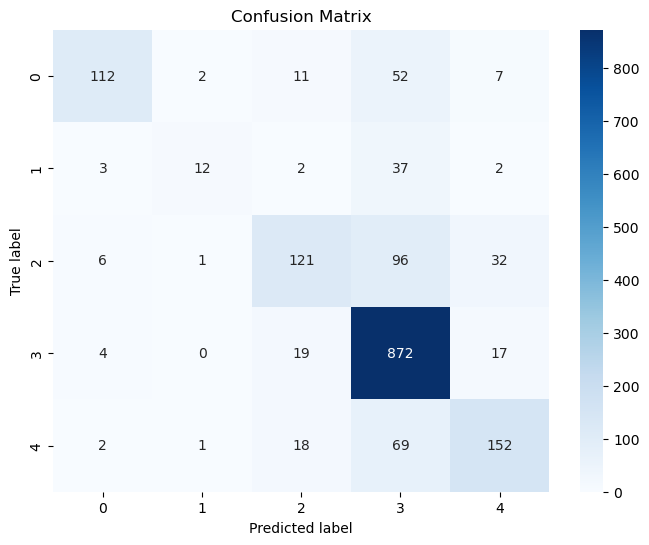

In [38]:
#Confusion matrix for FCN
plt.figure(figsize=(8, 6))
sns.heatmap(FCN_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

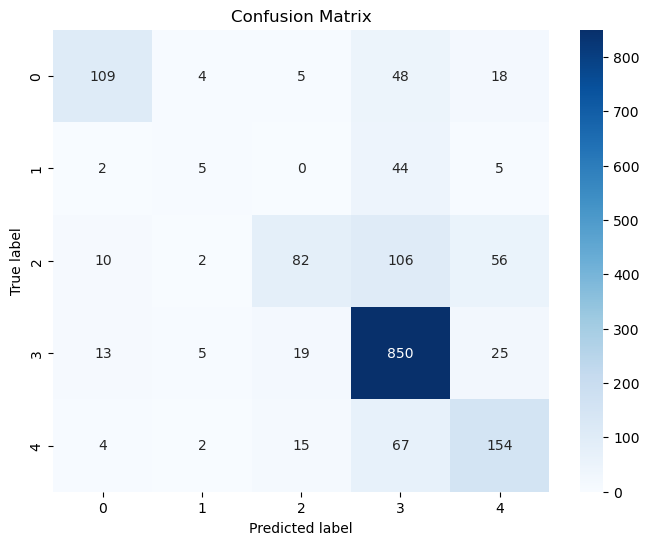

In [39]:
#Confusion matrix for AlexNet
plt.figure(figsize=(8, 6))
sns.heatmap(alexNet_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

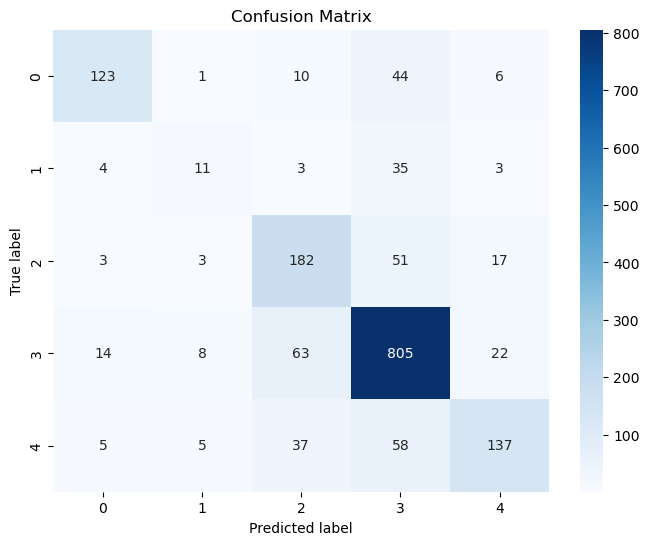

In [40]:
#Confusion matrix for ResNet50
plt.figure(figsize=(8, 6))
sns.heatmap(ResNet50_model_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

52/52 [==============================] - 19s 357ms/step


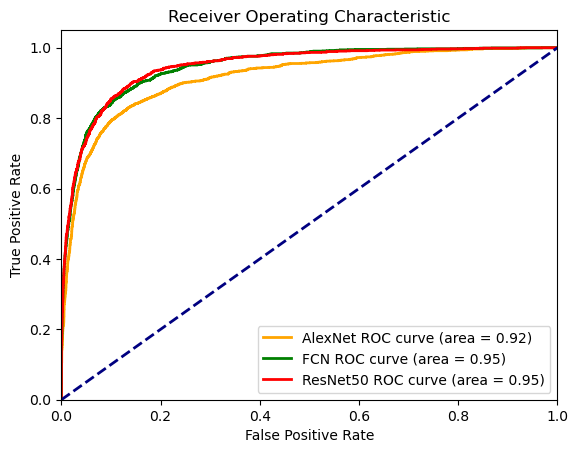

In [55]:


# Compute ROC curve and AUC for each model
fpr_alexnet, tpr_alexnet, _ = roc_curve(y_test.ravel(), alexNet_predict.ravel())
roc_auc_alexnet = auc(fpr_alexnet, tpr_alexnet)

fpr_fcn, tpr_fcn, _ = roc_curve(y_test.ravel(), FCN_predict.ravel())
roc_auc_fcn = auc(fpr_fcn, tpr_fcn)

fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test.ravel(), ResNet50_model_predict.ravel())
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Step 3: Plot ROC curves
plt.figure()
plt.plot(fpr_alexnet, tpr_alexnet, color='orange', lw=2, label='AlexNet ROC curve (area = %0.2f)' % roc_auc_alexnet)
plt.plot(fpr_fcn, tpr_fcn, color='green', lw=2, label='FCN ROC curve (area = %0.2f)' % roc_auc_fcn)
plt.plot(fpr_resnet50, tpr_resnet50, color='red', lw=2, label='ResNet50 ROC curve (area = %0.2f)' % roc_auc_resnet50)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [58]:
#Save the model to a specified location
alexNet_model.save("C:\\Users\\Windows10\\Desktop\\fyp\\alexNet_model.h5")
FCN_model.save("C:\\Users\\Windows10\\Desktop\\fyp\\SE_FCN_model.h5")
ResNet50_model.save("C:\\Users\\Windows10\\Desktop\\fyp\\ResNet50_model.h5")

In [35]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the models with custom_objects parameter
AlexNet_model = load_model("C:\\Users\\Windows10\\Desktop\\fyp\\alexNet_model.h5")
FCN_model = load_model("C:\\Users\\Windows10\\Desktop\\fyp\\SE_FCN_model.h5", custom_objects={'SqueezeExciteBlock': SqueezeExciteBlock})
ResNet50_model = load_model("C:\\Users\\Windows10\\Desktop\\fyp\\ResNet50_model.h5")

In [22]:
#Predict with the loaded model
AlexNet_predictions = AlexNet_model.predict(X_test)
FCN_predictions = FCN_model.predict(X_test)
ResNet50_predictions = ResNet50_model.predict(X_test)


52/52 [==============================] - 12s 221ms/step


In [21]:
AlexNet_predicted_classes = np.argmax(AlexNet_predictions, axis=1)
FCN_predicted_classes = np.argmax(FCN_predictions, axis=1)
ResNet50_predicted_classes = np.argmax(ResNet50_predictions, axis=1)
print(AlexNet_predictions[0])
print(AlexNet_predicted_classes[0])
print(FCN_predictions[0])
print(FCN_predicted_classes[0])
print(ResNet50_predictions[0])
print(ResNet50_predicted_classes[0])

[0.00763148 0.00147234 0.11560909 0.86200505 0.0132821 ]
3
[1.1171339e-02 9.5538481e-04 7.1663191e-03 9.7997153e-01 7.3544000e-04]
3
[0.01509388 0.00686994 0.13138004 0.8392524  0.0074038 ]
3
